Import necessary libraries

In [113]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

Data Collection

In [114]:
#Reads data from Melbourne Housing and Poperty Sales of Melbourne City. Sources claim to be scrapped from domain.com
dataset1 = pd.read_csv("raw_data/PrimaryData.csv")
dataset2 = pd.read_csv("raw_data/SecondaryData.csv")
dataset3 = pd.read_csv("raw_data/TertiaryData.csv")

Data Transformation

In [115]:
#converts data in the format day/month/year to YearSold which returns only the year
def YearSold(Date):
    Date = datetime.strptime(Date, '%d/%m/%Y')
    YearSold = Date.year
    return YearSold

#apply function to convert date to year on datasets 1 and 2
dataset1['YearSold'] = dataset1['Date'].apply(YearSold)
dataset2['YearSold'] = dataset2['Date'].apply(YearSold)
#Renames columns to match other datasets
dataset3.rename(columns={'Transfer_Year': 'YearSold','Small_Area':'Distance'}, inplace=True) 
#Replaces suburb data with Distance from suburb to CBD
dataset3['Distance'] = dataset3['Distance'].replace({
    'Carlton': 1.7,'Melbourne (CBD)': 0.0,'North Melbourne' :1.4,'South Yarra':2.5,'East Melbourne':1.4,'West Melbourne (Residential)':0.6,'Parkville':1.5,'Southbank':0.6,'Kensington':2.6,'Melbourne (Remainder)':None,'Docklands':0.5
})
#Resolves conflicting data input by creating new feature and replacing similar input
dataset3['Type'] = dataset3['Type'].replace({
    'House/Townhouse': 'ht', 
    'Residential Apartment': 'u'
})

C:\Users\LEGION\AppData\Local\Temp\ipykernel_26752\1938287008.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset3['Distance'] = dataset3['Distance'].replace({


Data Reduction

In [116]:
#Takes our two datasets and merges them together into one.
Merged_Data = pd.merge(dataset1,dataset2,how='outer')
Merged_Data = pd.merge(Merged_Data,dataset3,how='outer')

Data Cleaning

In [117]:
#Decided to drop suburb instead of distance. Distance will be easier to work with in a correlative model."""
""" multi-line commnents
Initially replaced missing data with average but it results to skew results.
So, Data is replaced with K-imputation instead.
Merged_Data['BuildingArea'] = Merged_Data['BuildingArea'].fillna(250.3)
Merged_Data['Landsize'] = Merged_Data['Landsize'].fillna(474)
Merged_Data['Rooms'] = Merged_Data['Rooms'].fillna(2.6)
"""

# Replaces missing value of Tertiary Dataset with its median price
Merged_Data['Price'] = Merged_Data['Price'].fillna(Merged_Data['Median_Price'])

# Drop irrelevant trasnfered columns and drop duplicate records
data = Merged_Data.drop(["Lattitude", "KeyID","Suburb","Address", "Method","SellerG","Postcode", "YearBuilt", "CouncilArea","Transaction_Count","Propertycount"], axis = 1)
data.drop(columns=['Date','Median_Price'],inplace=True)
data.drop_duplicates(inplace = True)
data

,Rooms,Type,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Longtitude,Regionname,YearSold
0,3.0,h,NaN,0.7,3.0,1.0,1.0,NaN,230.0,144.96793,Southern Metropolitan,2017
1,2.0,h,815000.0,1.2,2.0,1.0,0.0,0.0,NaN,144.94990,Southern Metropolitan,2016
3,3.0,h,1220000.0,1.2,3.0,1.0,1.0,0.0,NaN,144.96790,Southern Metropolitan,2016
5,3.0,h,700000.0,1.2,3.0,1.0,0.0,199.0,NaN,144.94960,Southern Metropolitan,2016
7,3.0,h,1875000.0,1.3,3.0,1.0,0.0,118.0,177.0,144.98804,Northern Metropolitan,2017
...,...,...,...,...,...,...,...,...,...,...,...,...
53585,NaN,u,685500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014
53586,NaN,u,566499.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015
53587,NaN,u,725000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016
53588,NaN,u,502107.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016


In [118]:
#Encoding the Type into a binary format. H = house, T = townhouse, U = unit
#We could encode the suburb into a binary format. probably a better way to do this but not sure. Location is surely correlated to price.
#Perhaps we should use distance to CBD instead?
data = pd.get_dummies(data, columns = ["Type","Regionname"])
data

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Longtitude,YearSold,...,Type_t,Type_u,Regionname_Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria
0,3.0,NaN,0.7,3.0,1.0,1.0,NaN,230.0,144.96793,2017,...,False,False,False,False,False,False,False,True,False,False
1,2.0,815000.0,1.2,2.0,1.0,0.0,0.0,NaN,144.94990,2016,...,False,False,False,False,False,False,False,True,False,False
3,3.0,1220000.0,1.2,3.0,1.0,1.0,0.0,NaN,144.96790,2016,...,False,False,False,False,False,False,False,True,False,False
5,3.0,700000.0,1.2,3.0,1.0,0.0,199.0,NaN,144.94960,2016,...,False,False,False,False,False,False,False,True,False,False
7,3.0,1875000.0,1.3,3.0,1.0,0.0,118.0,177.0,144.98804,2017,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53585,NaN,685500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,...,False,True,False,False,False,False,False,False,False,False
53586,NaN,566499.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,...,False,True,False,False,False,False,False,False,False,False
53587,NaN,725000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,...,False,True,False,False,False,False,False,False,False,False
53588,NaN,502107.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016,...,False,True,False,False,False,False,False,False,False,False


Using KNN algorithm to impute data in order to fill in missing data

In [119]:
# Use data except for columns price and type since type is string while price is the dependent variable
knn_dataset = data.drop(['Price'], axis=1)
Missing_Columns = ['Landsize', 'Rooms', 'BuildingArea','Longtitude','Car','Bathroom','Bedroom2','Type_t','Type_u'
                   ,'Regionname_Eastern Metropolitan','Regionname_Eastern Victoria','Regionname_Northern Metropolitan','Regionname_Northern Victoria','Regionname_South-Eastern Metropolitan','Regionname_Southern Metropolitan','Regionname_Western Metropolitan','Regionname_Western Victoria']
imputer = KNNImputer(n_neighbors=5)
print("Missing values before\n", data[Missing_Columns].isnull().sum(),"\n")

# Fit the imputer and transform the relevant columns
Data_imputed = imputer.fit_transform(knn_dataset[Missing_Columns])
Data_imputed_df = pd.DataFrame(Data_imputed, columns=Missing_Columns, index=knn_dataset.index)

# Fill missing values in the original DataFrame
data[Missing_Columns] = data[Missing_Columns].fillna(Data_imputed_df)
print("Missing values after\n", data[Missing_Columns].isnull().sum(),"\n")

# Print the first five rows replaced by imputed data
print("Imputed Data:\n", Data_imputed_df.head())

# Remove records with NA / missing field value
data.dropna(inplace=True)

#Returns an csv file for the combined data
#https://stackoverflow.com/questions/16923281/writing-a-pandas-dataframe-to-csv-file
data.to_csv("processed_data/CombinedProcessedData.csv", encoding='utf-8', index=False)

Missing values before
 Landsize                                 11359
Rooms                                      337
BuildingArea                             20657
Longtitude                                7534
Car                                       8286
Bathroom                                  7784
Bedroom2                                  7775
Type_t                                       0
Type_u                                       0
Regionname_Eastern Metropolitan              0
Regionname_Eastern Victoria                  0
Regionname_Northern Metropolitan             0
Regionname_Northern Victoria                 0
Regionname_South-Eastern Metropolitan        0
Regionname_Southern Metropolitan             0
Regionname_Western Metropolitan              0
Regionname_Western Victoria                  0
dtype: int64 

Missing values after
 Landsize                                 0
Rooms                                    0
BuildingArea                             0
Longtitude  

Splitting dataset into 80/20 split for training and testing data

In [120]:
X = data.drop(['Price'], axis = 1)
Y = data['Price']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)
#Joining the training data back together. 
train_data = X_train.join(Y_train)

Data Visualization

Heatmap chart uses color intensity where dark colors infers neagative value while brighter colors infers positive value

<Axes: >

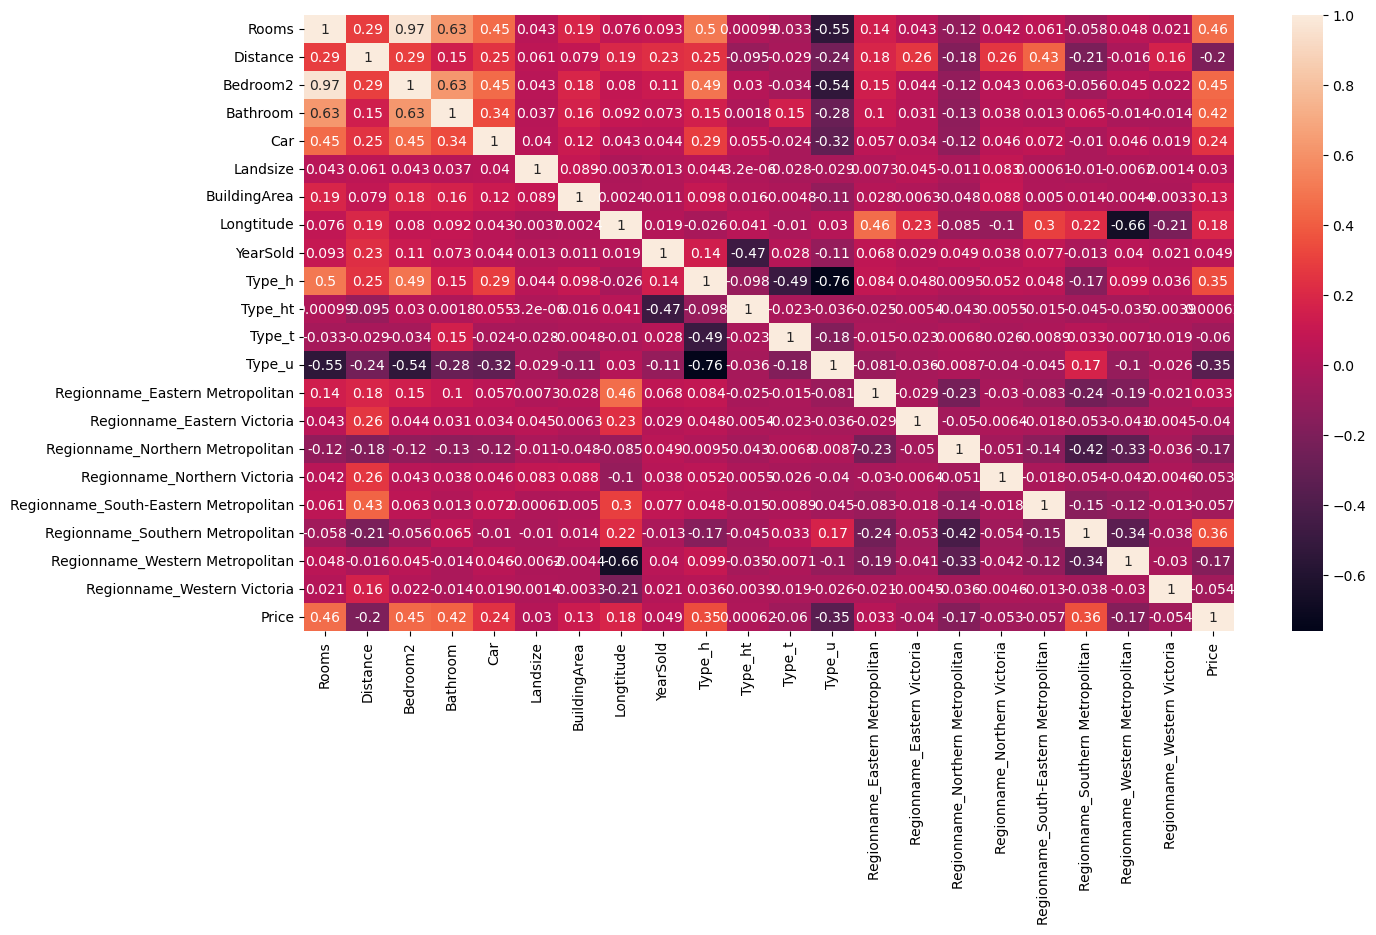

In [121]:
#Lets look at how different variables correlate to price. Seaborn heatmap is a great way
#to view this.
plt.figure(figsize = (15,8))
sns.heatmap(train_data.corr(), annot=True)

Bar charts

array([[<Axes: title={'center': 'Rooms'}>,
        <Axes: title={'center': 'Distance'}>,
        <Axes: title={'center': 'Bedroom2'}>],
       [<Axes: title={'center': 'Bathroom'}>,
        <Axes: title={'center': 'Car'}>,
        <Axes: title={'center': 'Landsize'}>],
       [<Axes: title={'center': 'BuildingArea'}>,
        <Axes: title={'center': 'Longtitude'}>,
        <Axes: title={'center': 'YearSold'}>],
       [<Axes: title={'center': 'Price'}>, <Axes: >, <Axes: >]],
      dtype=object)

<Figure size 2500x1000 with 0 Axes>

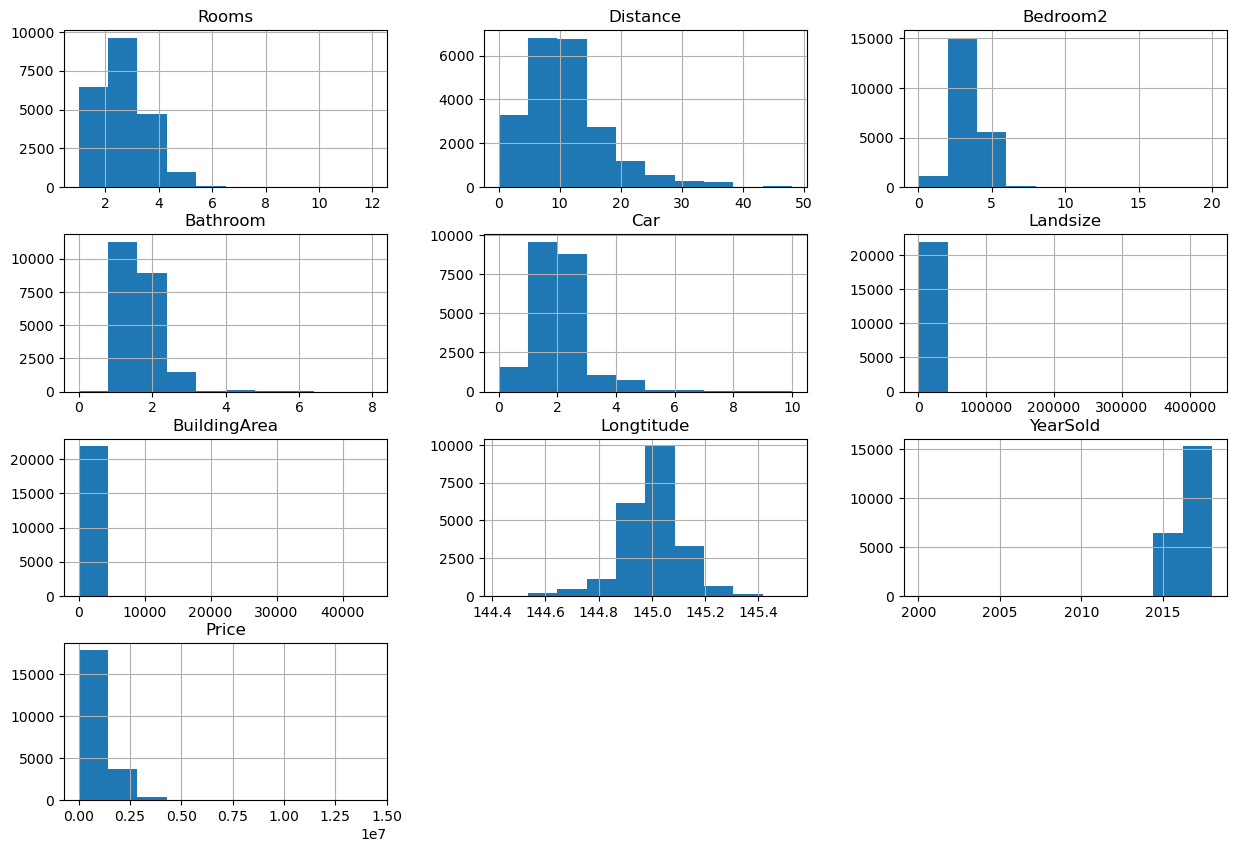

In [122]:
#Features are somewhat skewed, ideally we want a bell curve type distribution 
plt.figure(figsize=(25,10))
train_data.hist(figsize=(15,10))

In [123]:
#Normalising data using logirithms. 
train_data['Rooms'] = np.log (train_data['Rooms']+1)
train_data['Distance'] = np.log (train_data['Distance']+1)
train_data['Price'] = np.log (train_data['Price']+1)
train_data['Landsize'] = np.log (train_data['Landsize']+1)
train_data['BuildingArea'] = np.log (train_data['BuildingArea']+1)
train_data['YearSold'] = np.log (train_data['YearSold']+1)
train_data['Bedroom2'] = np.log (train_data['Bedroom2']+1)
train_data['Longtitude'] = np.log (train_data['Longtitude']+1)
train_data['Car'] = np.log (train_data['Car']+1)
train_data['Bathroom'] = np.log (train_data['Bathroom']+1)

array([[<Axes: title={'center': 'Rooms'}>,
        <Axes: title={'center': 'Distance'}>,
        <Axes: title={'center': 'Bedroom2'}>],
       [<Axes: title={'center': 'Bathroom'}>,
        <Axes: title={'center': 'Car'}>,
        <Axes: title={'center': 'Landsize'}>],
       [<Axes: title={'center': 'BuildingArea'}>,
        <Axes: title={'center': 'Longtitude'}>,
        <Axes: title={'center': 'YearSold'}>],
       [<Axes: title={'center': 'Price'}>, <Axes: >, <Axes: >]],
      dtype=object)

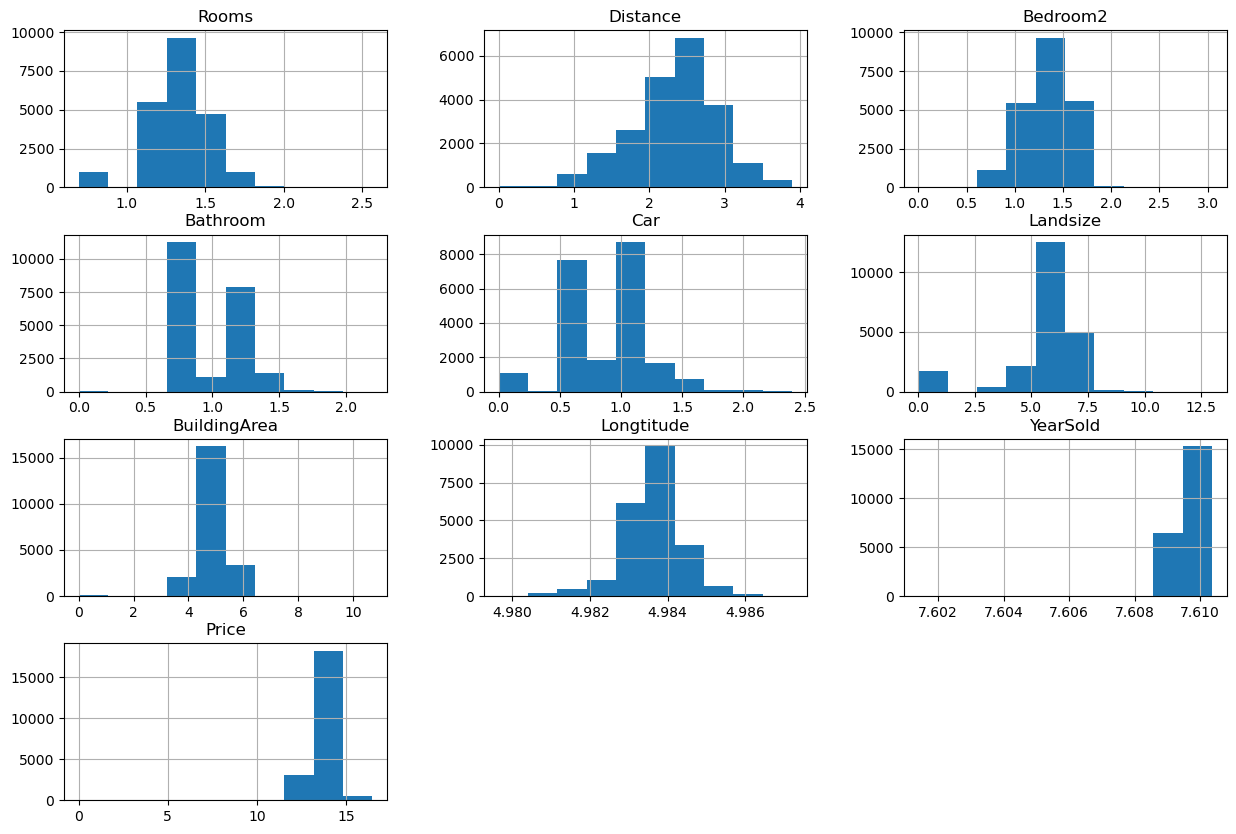

In [124]:
#Showing data after normalising with logarithms. 
train_data.hist(figsize=(15,10))

Data Analysis

Linear Regression Model and regression score

In [125]:
#Simple Linear Regression model, scaling our training data too. Then lastly fitting training data to line. 
reg = LinearRegression()
scaler = StandardScaler()
X_train_s= scaler.fit_transform(X_train)
reg.fit(X_train_s,Y_train)

LinearRegression()

In [126]:
#Normalising our test data using logarithms. 
test_data = X_test.join(Y_test)

test_data['Rooms'] = np.log (test_data['Rooms']+1)
test_data['Distance'] = np.log (test_data['Distance']+1)
test_data['Price'] = np.log (test_data['Price']+1)
test_data['Landsize'] = np.log (test_data['Landsize']+1)
test_data['BuildingArea'] = np.log (test_data['BuildingArea']+1)
test_data['Landsize'] = np.log (test_data['Landsize']+1)
test_data['Bedroom2'] = np.log (test_data['Bedroom2']+1)
test_data['Car'] = np.log (test_data['Car']+1)
test_data['Bathroom'] = np.log (test_data['Bathroom']+1)

In [127]:
X_test_s = scaler.transform(X_test)
reg.score(X_test_s,Y_test)

0.5716180214748554

Random Forest Regressor model and forest model score

In [128]:
forest = RandomForestRegressor()
forest.fit(X_train_s, Y_train)

RandomForestRegressor()

In [129]:
forest.score(X_test_s,Y_test)

0.704124749554778

Grid search CV and best forest search score

In [130]:

grid = {
    "n_estimators": [3,10,30],
    "max_features": [2,4,6,8],
}

grid_search = GridSearchCV(forest,grid, cv = 5,
                           return_train_score= True,
                           scoring="neg_mean_squared_error")

grid_search.fit(X_train_s, Y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': [2, 4, 6, 8],
                         'n_estimators': [3, 10, 30]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [131]:
best_forest = grid_search.best_estimator_
best_forest.score(X_test_s, Y_test)

0.7247519737272264